In [1]:
import tables
import pandas as pd
import numpy as np
import cv2
from scipy import stats
import os
import re
from matplotlib import pyplot as plt

In [2]:
def clean_df(df):
    #remove redundant top level
    data = df['DLC_3D']
    #flatten data frame
    data.columns = [' '.join(col).strip() for col in data.columns.values]
    clean = data.copy()
    return data

In [3]:
traj_data = '/home/spencerloggia/Documents/3d_csv/'
ground_dir = os.path.join(traj_data, 'ground')
df = None
for file in os.listdir(ground_dir):
    if '_3D' in file:
        # found the ground 3D file.
        df = pd.read_hdf(os.path.join(traj_data, 'ground', file))
if df is None:
    raise RuntimeError

data = clean_df(df)
data.describe()

,bodypart1 x,bodypart1 y,bodypart1 z,bodypart2 x,bodypart2 y,bodypart2 z,bodypart3 x,bodypart3 y,bodypart3 z,bodypart4 x,bodypart4 y,bodypart4 z,bodypart5 x,bodypart5 y,bodypart5 z,bodypart6 x,bodypart6 y,bodypart6 z
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,8.000000,8.000000,8.000000
mean,-67.420921,-9.579509,34.373593,-65.403303,-10.327192,35.003742,-64.571639,-8.502988,38.209452,NaN,NaN,NaN,NaN,NaN,NaN,-67.348063,-3.476952,42.738584
std,0.094475,0.025063,0.092049,0.139369,0.040547,0.143174,0.056234,0.047892,0.051156,NaN,NaN,NaN,NaN,NaN,NaN,0.561364,0.576941,0.380990
min,-67.636582,-9.635721,34.281370,-65.732041,-10.403526,34.728726,-64.651576,-8.570715,38.143657,NaN,NaN,NaN,NaN,NaN,NaN,-68.713201,-4.901770,42.504744
25%,-67.446327,-9.582644,34.317618,-65.433610,-10.342120,34.945020,-64.631825,-8.545909,38.169643,NaN,NaN,NaN,NaN,NaN,NaN,-67.280320,-3.308008,42.520997
50%,-67.377304,-9.575714,34.342723,-65.401158,-10.328114,34.979705,-64.565333,-8.491752,38.201891,NaN,NaN,NaN,NaN,NaN,NaN,-67.184662,-3.282421,42.626253
75%,-67.363212,-9.569383,34.384343,-65.338423,-10.308243,35.044200,-64.523886,-8.471969,38.232603,NaN,NaN,NaN,NaN,NaN,NaN,-67.059928,-3.244576,42.721179
max,-67.309839,-9.525595,34.607125,-65.121884,-10.241188,35.355762,-64.499141,-8.420467,38.314581,NaN,NaN,NaN,NaN,NaN,NaN,-67.026294,-3.225914,43.651725


In [4]:
ref_coords = data.iloc[:, list(range(0, 9))]
ref_coords.dropna(inplace=True)
ref_coords.head()
    

<ipython-input-4-9ffa5b8b6e67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_coords.dropna(inplace=True)


,bodypart1 x,bodypart1 y,bodypart1 z,bodypart2 x,bodypart2 y,bodypart2 z,bodypart3 x,bodypart3 y,bodypart3 z
0,-67.309839,-9.525595,34.288750,-65.364649,-10.324005,34.964304,-64.549225,-8.437722,38.201891
1,-67.434141,-9.575714,34.365238,-65.312331,-10.284602,34.897023,-64.640977,-8.478098,38.228091
2,-67.402036,-9.582869,34.342446,-65.401004,-10.333982,34.979705,-64.582693,-8.491752,38.193215
3,-67.374423,-9.582419,34.318321,-65.402004,-10.331022,34.975594,-64.533767,-8.501814,38.175310
4,-67.325589,-9.569082,34.281370,-65.121884,-10.241188,34.728726,-64.499141,-8.465562,38.163976


g1 is the left of the hole, g2 is the top, g3 if right

In [5]:
g1_coords = data.iloc[:, list(range(0, 3))].to_numpy()
g2_coords = data.iloc[:, list(range(3, 6))].to_numpy()
g3_coords = data.iloc[:, list(range(6, 9))].to_numpy()

g1_vec = np.median(g1_coords, axis=0)
g2_vec = np.median(g2_coords, axis=0)
g3_vec = np.median(g3_coords, axis=0)

print(g1_vec)
print(g2_vec)
print(g3_vec)

[-67.37730388  -9.57571405  34.34272269]
[-65.40115782 -10.32811371  34.97970453]
[-64.56533281  -8.49175162  38.20189089]


i_m is paralel to the ground along the mask

j_m is orthoganal to the ground along the mask

k_m is orthoganal to the mask

In [6]:
i_mr = (g1_vec - g3_vec)
i_m = i_mr / np.linalg.norm(i_mr)

k_mr = np.cross(i_m, (g1_vec - g2_vec))
k_m = k_mr / np.linalg.norm(k_mr)

j_mr = np.cross(i_m, k_m)
j_m = j_mr / np.linalg.norm(j_mr)

#check
print(np.dot(i_m, k_m))
print(np.dot(i_m, j_m))
print(np.dot(k_m, j_m))

2.7755575615628914e-17
0.0
1.1102230246251565e-16


All bodypart vector must be transformed with T when loaded to move origin to mask coordinate system.

In [7]:
# construct change of basis matrix 
T = np.concatenate([i_m.reshape(-1, 1), j_m.reshape(-1, 1), k_m.reshape(-1, 1)], axis=1).T
print(T)

[[-0.57428636 -0.22137669 -0.78815451]
 [ 0.68684273 -0.65416593 -0.31672384]
 [ 0.44546856  0.72322838 -0.52772955]]


Load all the tracking data and generated transformed csv files

<ipython-input-8-badfbf1fe968>:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


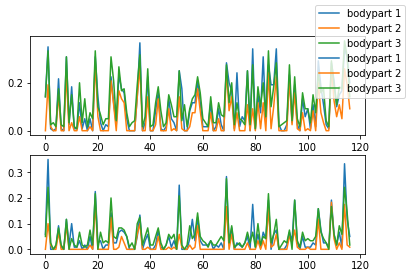

In [8]:
files = os.listdir(traj_data)
save_loc = os.path.join(traj_data, 'transformed')
missing_b1 = []
missing_b2 = []
missing_b3 = []

missing_b1_inter = []
missing_b2_inter = []
missing_b3_inter = []
for f in files:
    if '_3D.h5' in f:
        clip_id = re.split(r'_|-', f)[1]
        trial_df = pd.read_hdf(os.path.join(traj_data, f))
        trial_df = clean_df(trial_df)
        
        #remove empty data on ends
        first = trial_df.first_valid_index()
        last = trial_df.last_valid_index()
        trial_df = trial_df[first:last]
        
        # count nans before interpolation
        missing_b1.append(trial_df.iloc[:, list(range(0, 3))].isna().sum().sum() / 360)
        missing_b2.append(trial_df.iloc[:, list(range(3, 6))].isna().sum().sum() / 360)
        missing_b3.append(trial_df.iloc[:, list(range(6, 9))].isna().sum().sum() / 360)
        
        
        # interpolate with limit of 5
        trial_df.interpolate(method='linear', axis=0, limit=5, limit_direction='both', inplace=True, limit_area='inside')
        
        # count nans before interpolation
        missing_b1_inter.append(trial_df.iloc[:, list(range(0, 3))].isna().sum().sum() / 360)
        missing_b2_inter.append(trial_df.iloc[:, list(range(3, 6))].isna().sum().sum() / 360)
        missing_b3_inter.append(trial_df.iloc[:, list(range(6, 9))].isna().sum().sum() / 360)
        
        # drop remaining nans
        trial_df.dropna(inplace=True)
        
        num_trial = trial_df.to_numpy()
        
        #transform into mask coordinate system
        num_trial[:, :3] = np.matmul(T, num_trial[:, :3].T).T
        num_trial[:, 3:6] = np.matmul(T, num_trial[:, 3:6].T).T
        num_trial[:, 6:9] = np.matmul(T, num_trial[:, 6:9].T).T
        trial_df.iloc[:] = num_trial
        fname = 'clip_' + str(clip_id) + '_transformed_3D.csv'
        trial_df.to_csv(os.path.join(save_loc, fname))

fig, ax = plt.subplots(2)
ax[0].suptitle = "Percent Missing Per Body Part Before And After Interpolation"
ax[0].plot(missing_b1, label="bodypart 1")
ax[0].plot(missing_b2, label="bodypart 2")
ax[0].plot(missing_b3, label="bodypart 3")

ax[1].plot(missing_b1_inter, label="bodypart 1")
ax[1].plot(missing_b2_inter, label="bodypart 2")
ax[1].plot(missing_b3_inter, label="bodypart 3")

fig.legend()
fig.show()


Now we will get angles from transformed coordinates

In [9]:
# return the normal vector (orthogonal to the head) and the ear vector (between the two ears)
def get_normals(b1_coords:np.ndarray, b2_coords:np.ndarray, b3_coords:np.ndarray):
    """
    b1_coord: 3D coordinates for left ear base
    b2_coord: 3D coordinates for right ear base 
    b3_coords: 3D coordinates for nose
    """
    ear_vec = b1 - b2
    nose_vec = np.mean(np.stack([(b3 - b1), (b3 - b2)], axis=2), axis=2)
    normal_vec = np.cross(ear_vec, nose_vec)
    normal_vec = normal_vec / np.linalg.norm(normal_vec, axis=1).reshape(-1, 1)
    ear_vec = ear_vec / np.linalg.norm(ear_vec, axis=1).reshape(-1, 1)
    nose_vec = nose_vec / np.linalg.norm(nose_vec, axis=1).reshape(-1, 1) * -1
    return normal_vec, ear_vec, nose_vec

In [10]:
def compute_roll(vec):
    proj = vec[:, (0, 1)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    angle = np.arccos(np.dot(proj, np.array([1, 0])))
    return angle

def compute_pitch(vec):
    proj = vec[:, (1, 2)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    angle = np.arccos(np.dot(proj, np.array([1, 0])))
    return angle

def compute_yaw(vec):
    proj = vec[:, (0, 2)]
    proj /= np.linalg.norm(proj, axis=1).reshape(-1, 1)
    angle = np.arccos(np.dot(proj, np.array([0, 1])))
    return angle

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


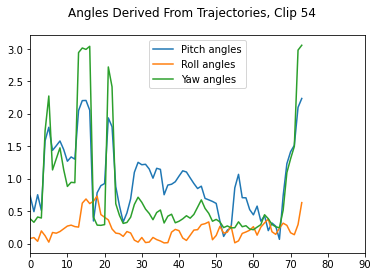

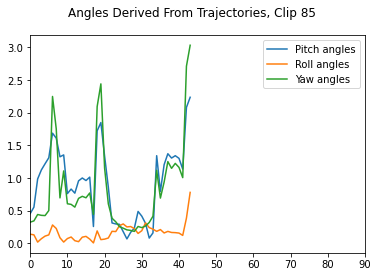

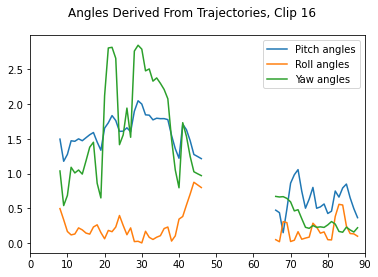

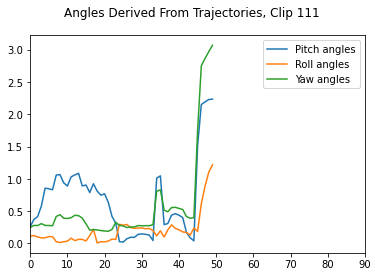

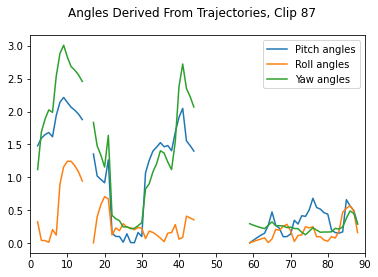

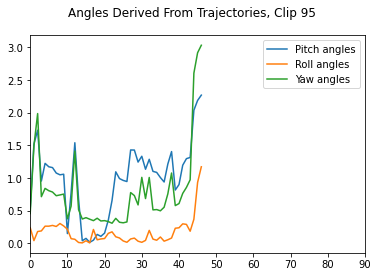

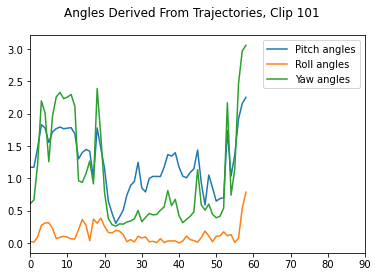

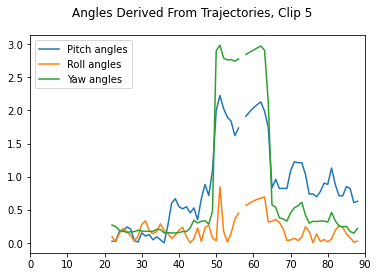

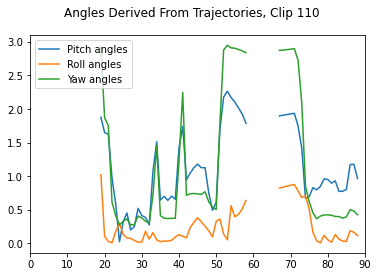

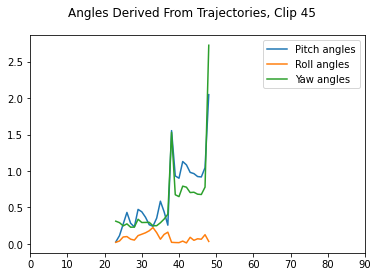

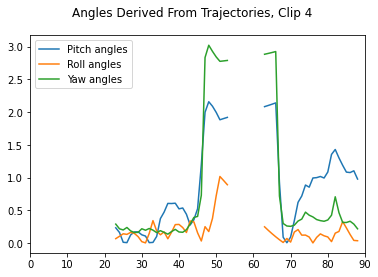

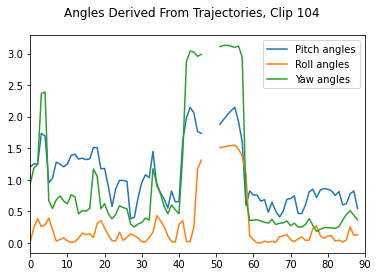

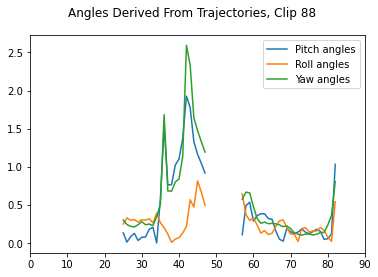

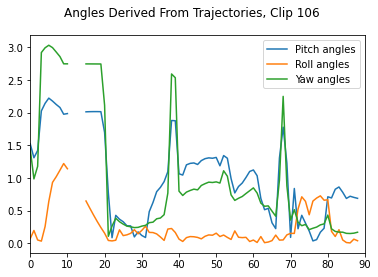

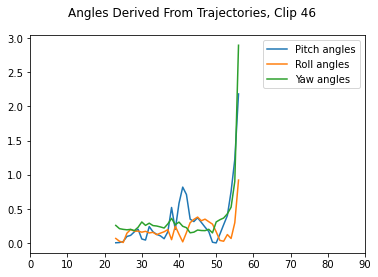

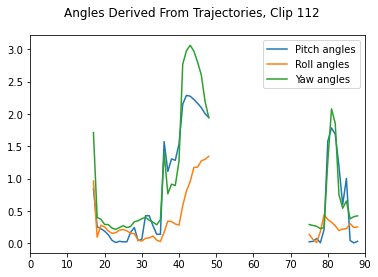

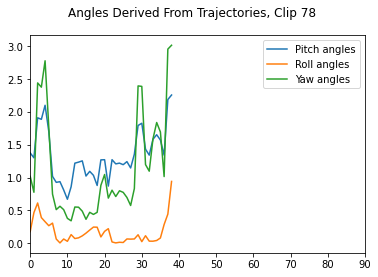

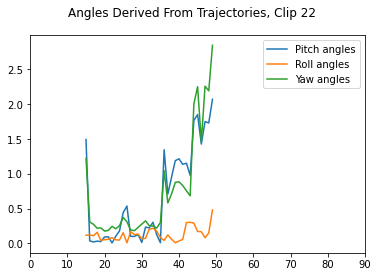

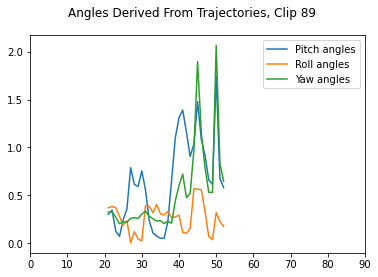

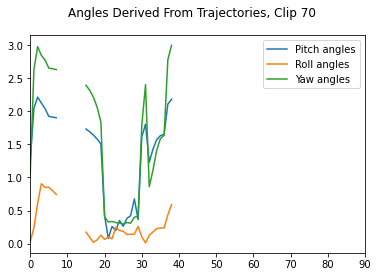

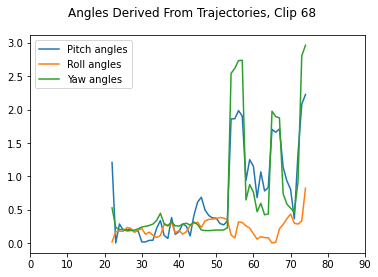

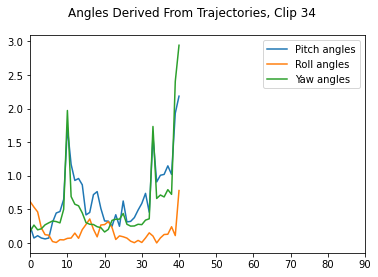

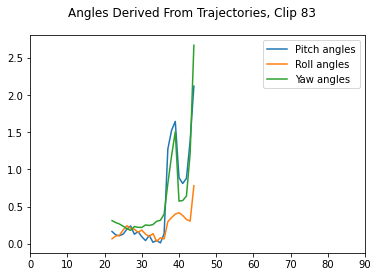

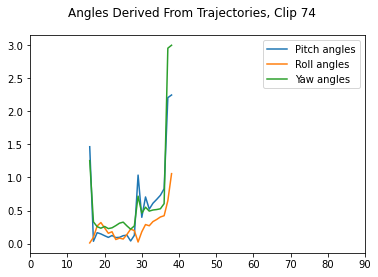

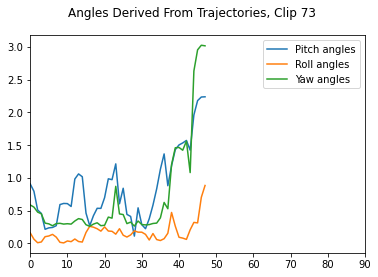

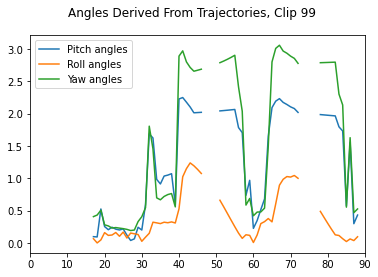

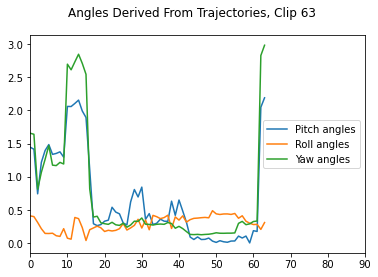

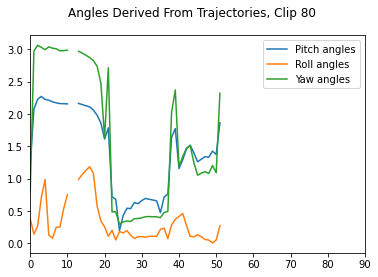

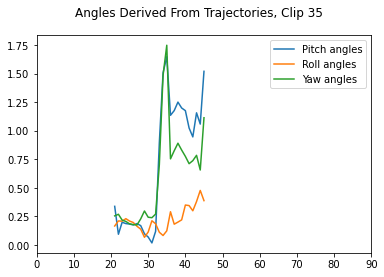

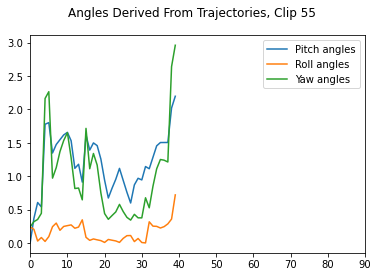

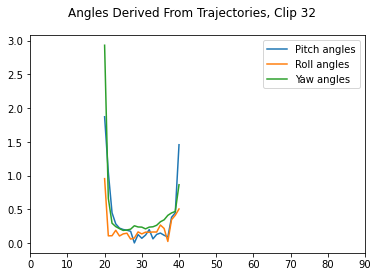

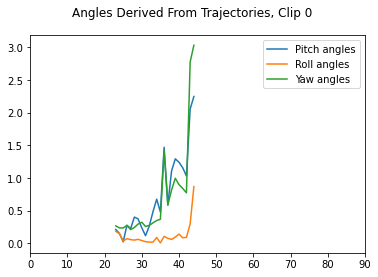

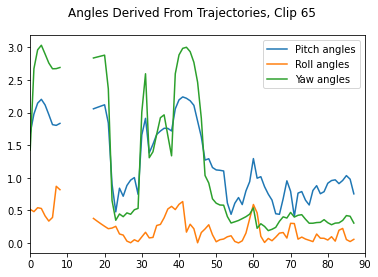

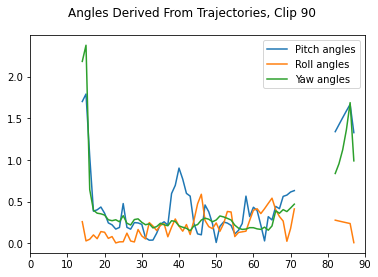

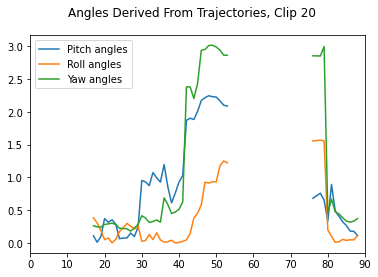

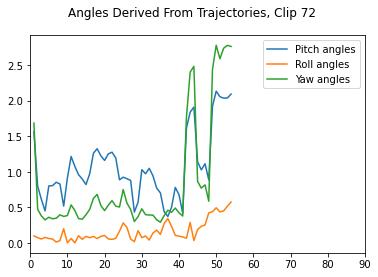

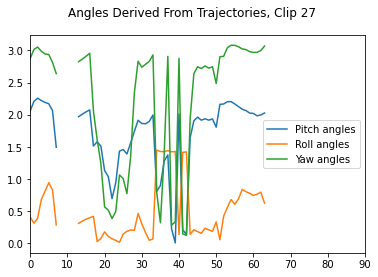

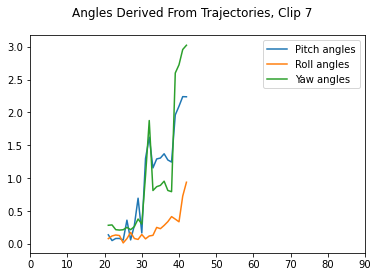

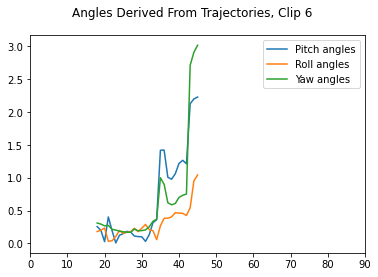

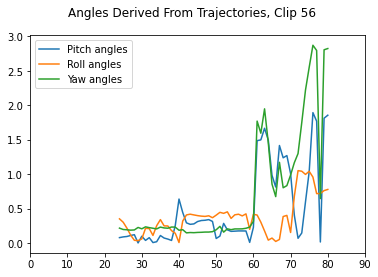

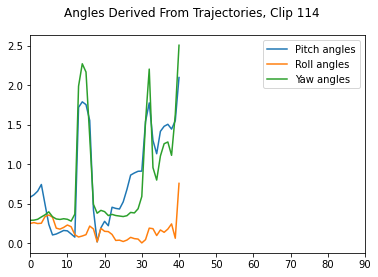

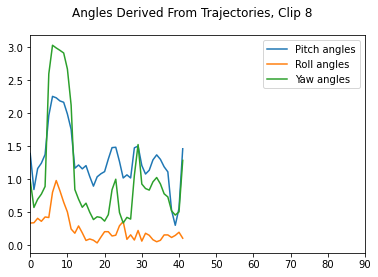

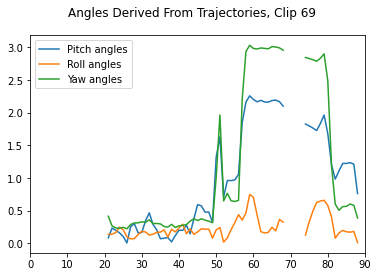

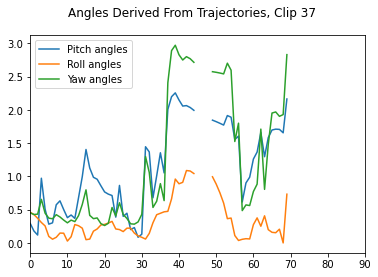

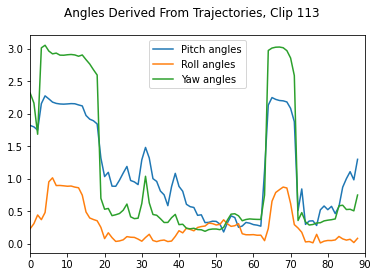

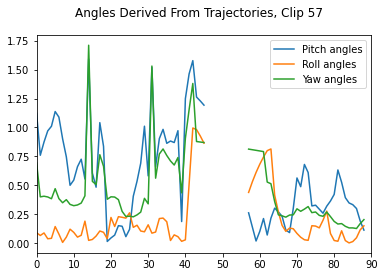

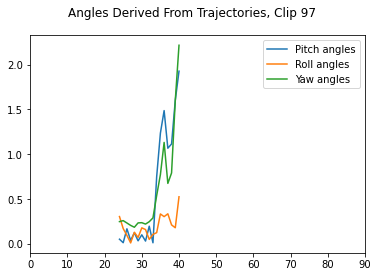

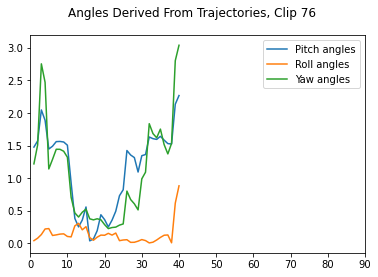

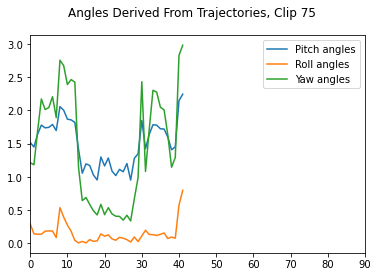

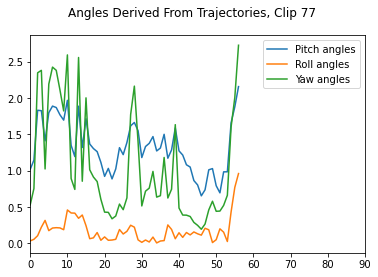

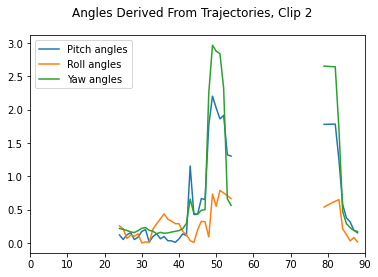

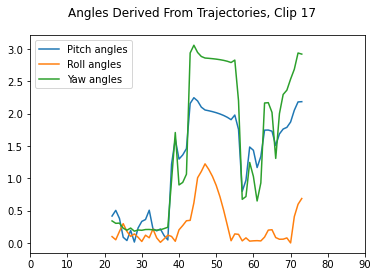

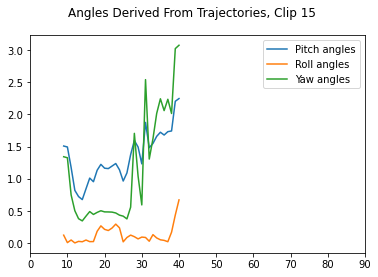

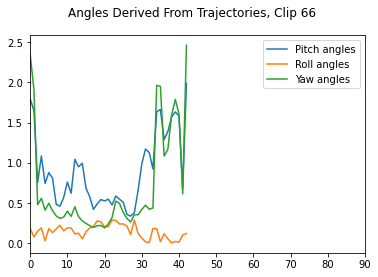

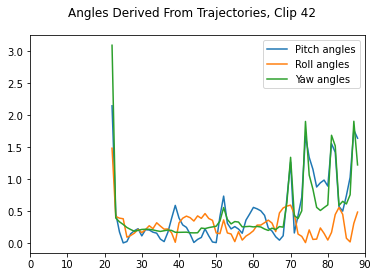

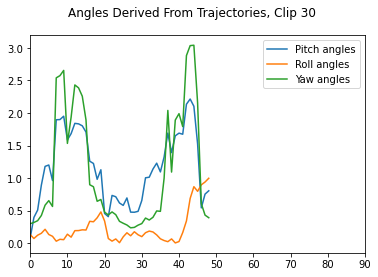

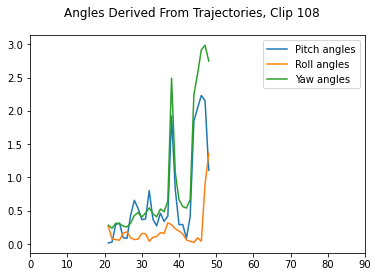

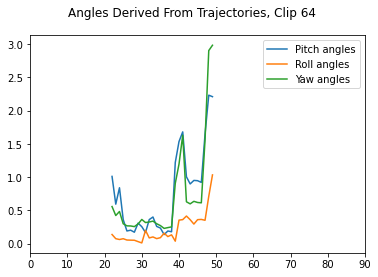

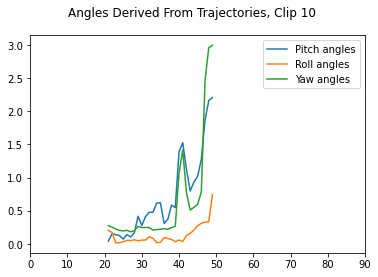

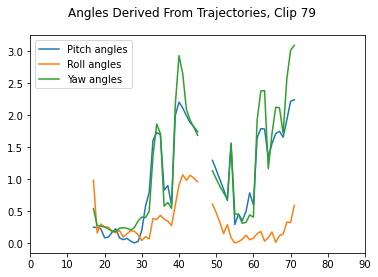

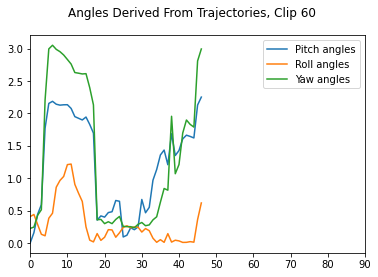

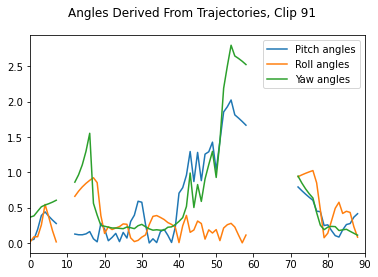

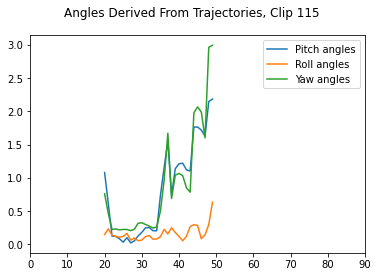

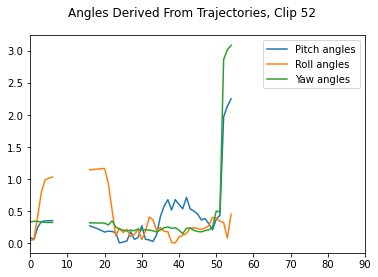

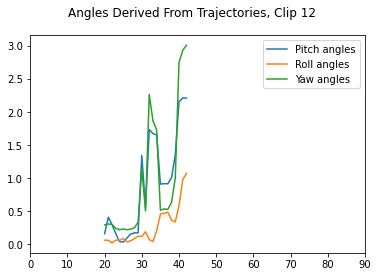

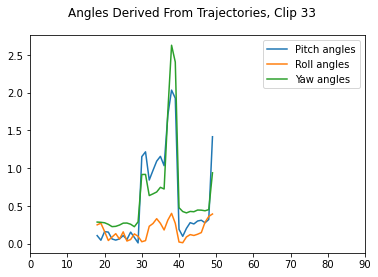

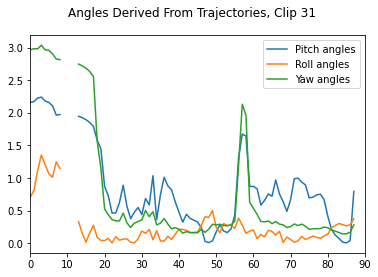

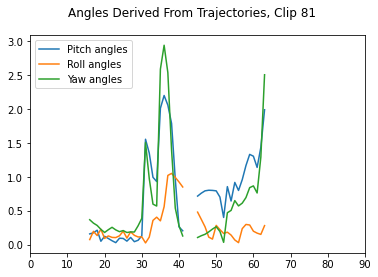

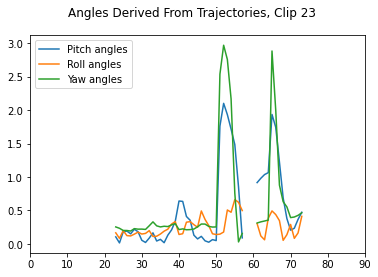

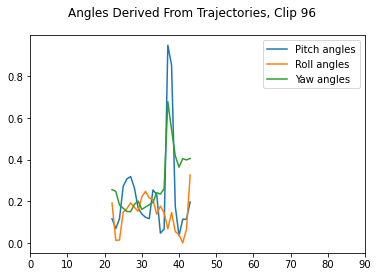

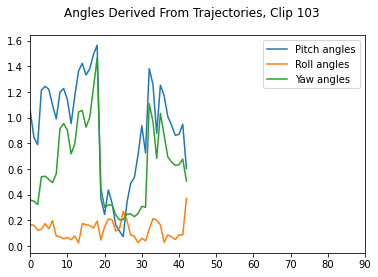

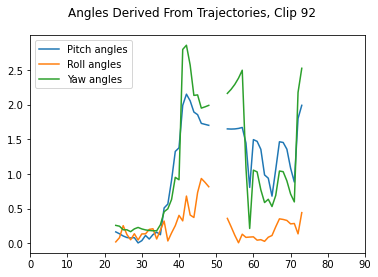

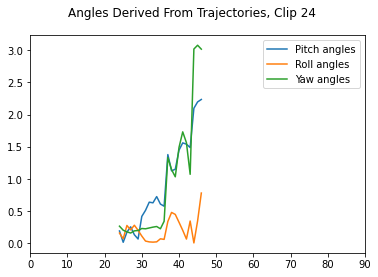

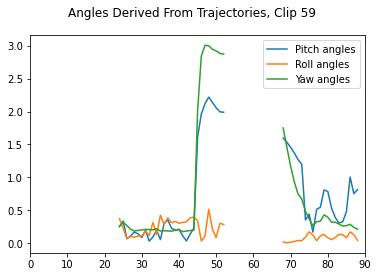

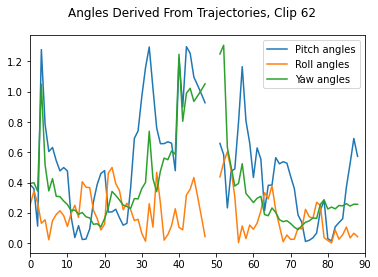

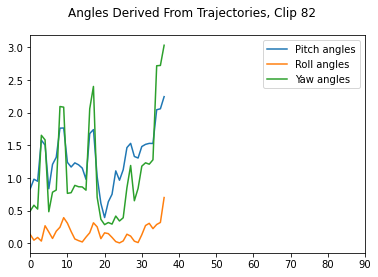

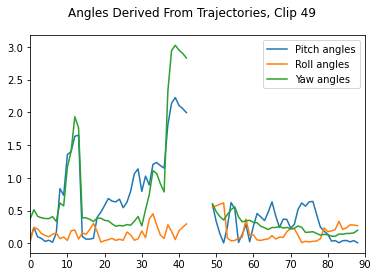

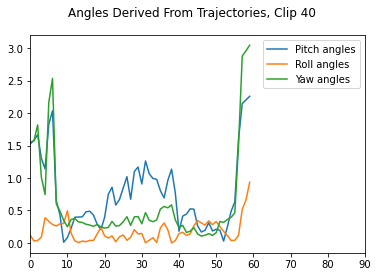

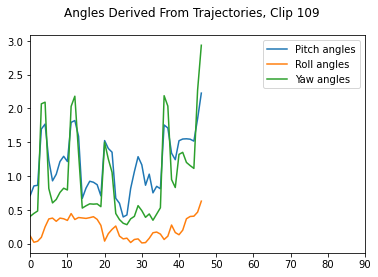

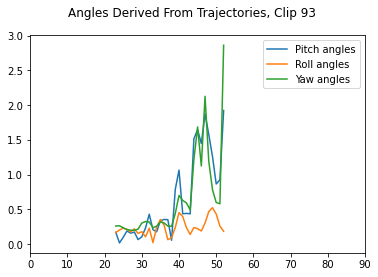

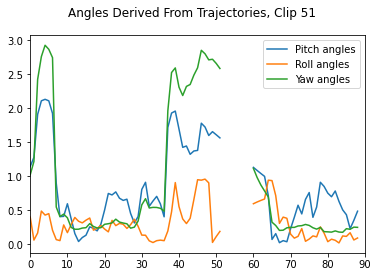

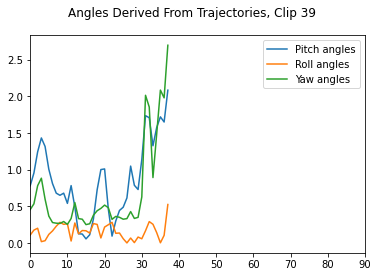

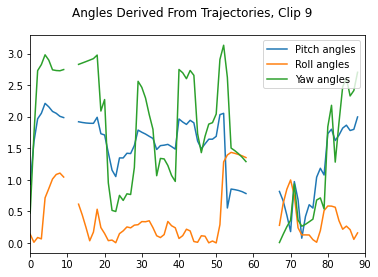

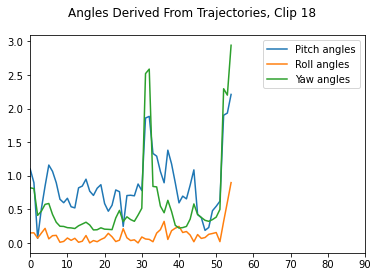

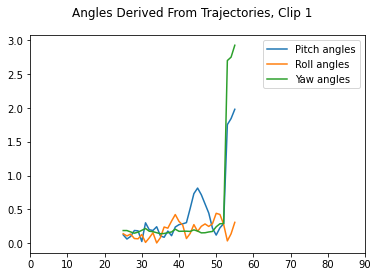

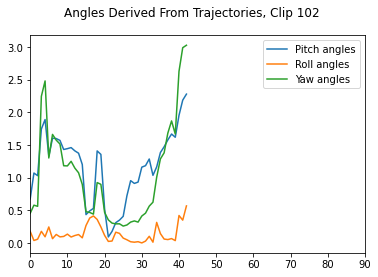

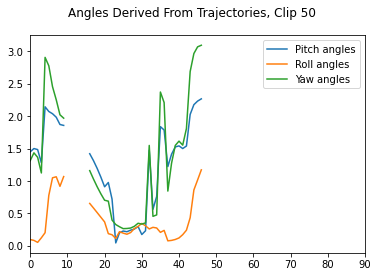

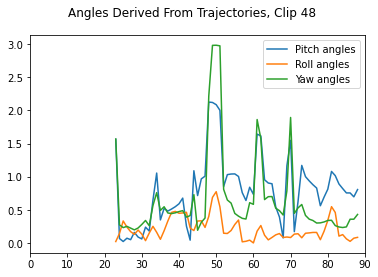

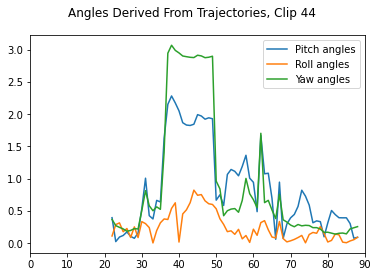

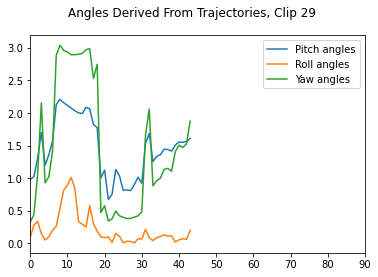

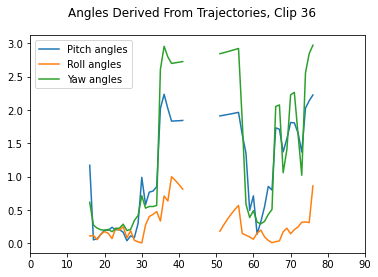

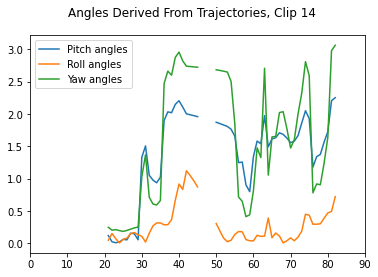

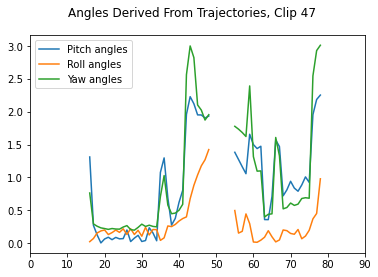

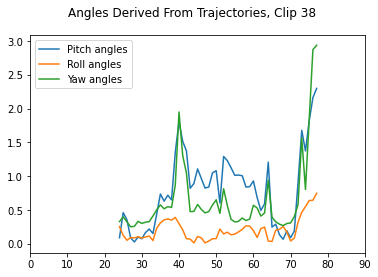

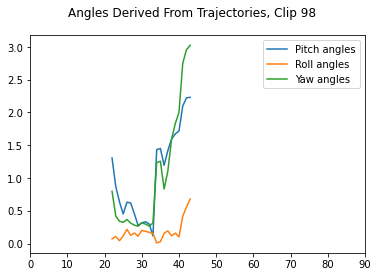

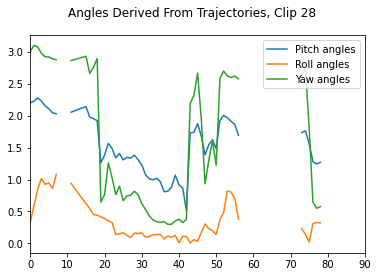

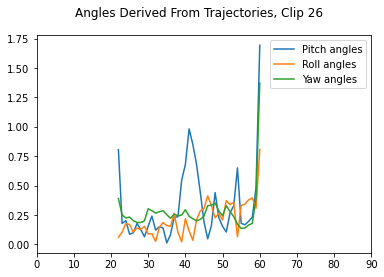

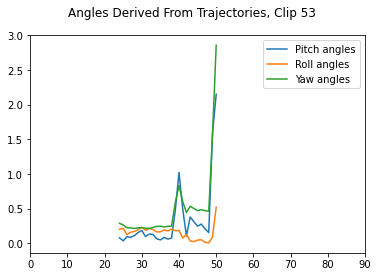

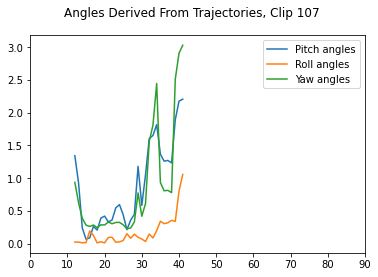

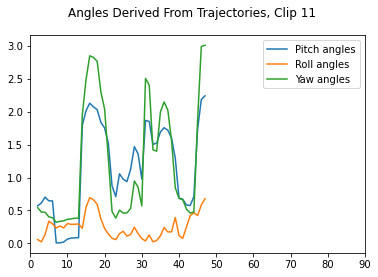

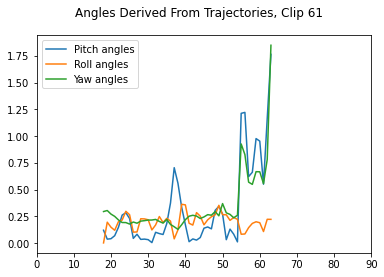

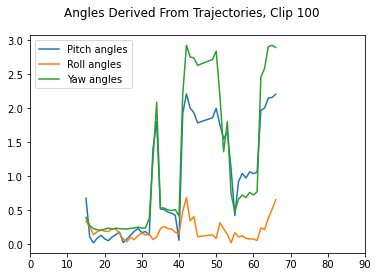

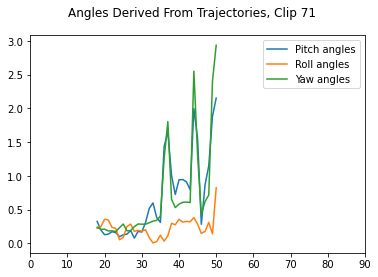

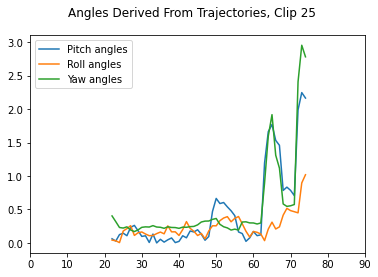

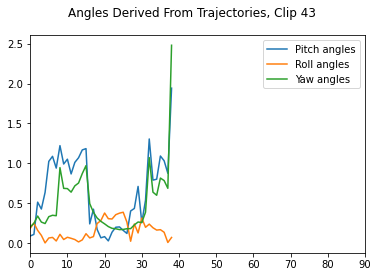

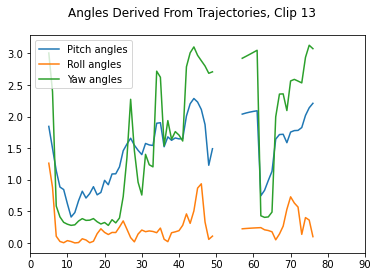

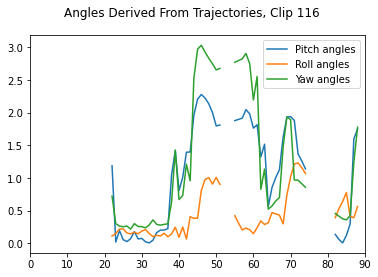

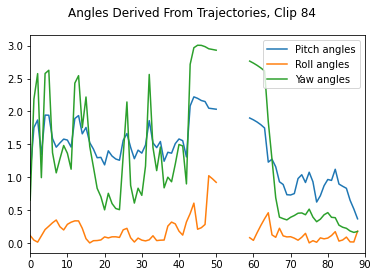

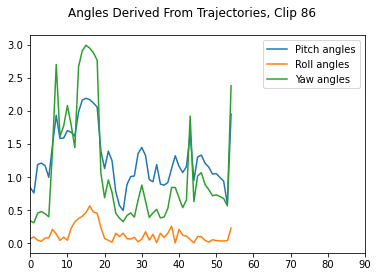

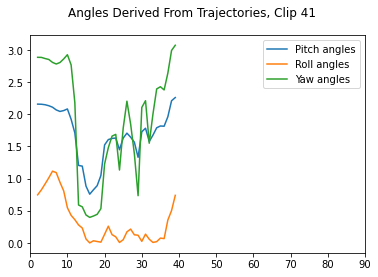

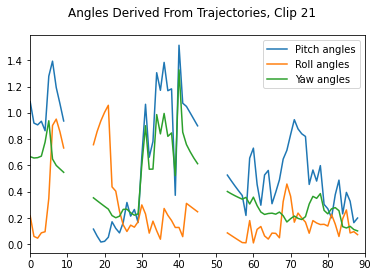

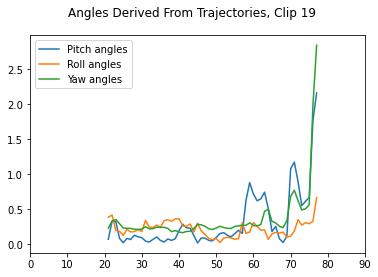

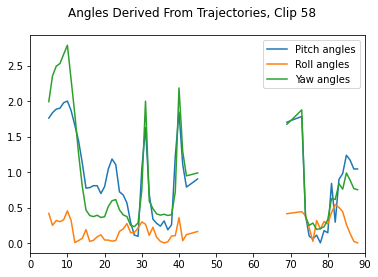

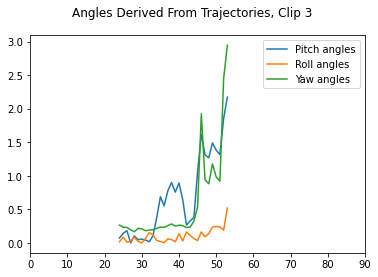

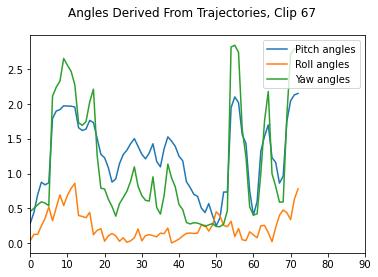

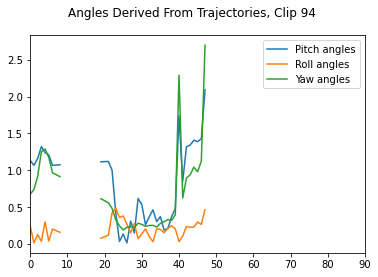

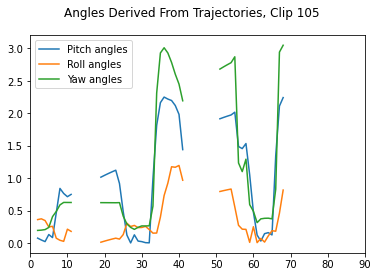

In [14]:
transformed_files = os.listdir(os.path.join(traj_data, 'transformed'))
save_loc = os.path.join(traj_data, 'angles')
for f in transformed_files:
    if '_3D.csv' in f:
        clip_id = re.split(r'_|-', f)[1]
        trial_df = pd.read_csv(os.path.join(traj_data, 'transformed', f))
        num_trial = trial_df.to_numpy()
        
        index = num_trial[:, 0].astype(np.int)
        
        b1 = num_trial[:, 1:4]
        b2 = num_trial[:, 4:7]
        b3 = num_trial[:, 7:10]
        
        norm, ear, nose = get_normals(b1, b2, b3)
        roll_angles = compute_roll(ear)
        pitch_angles = compute_pitch(norm)
        yaw_angles = compute_yaw(nose)
        
        roll_map = np.empty([90]) * np.nan
        pitch_map = np.empty([90]) * np.nan
        yaw_map = np.empty([90]) * np.nan
        
        roll_map[index] = roll_angles
        pitch_map[index] = pitch_angles
        yaw_map[index] = yaw_angles
        
        df = pd.DataFrame(np.stack([pitch_angles, yaw_angles, roll_angles], axis=1), columns=["Pitch", "Yaw", "Roll"])
        df.to_csv(os.path.join(save_loc, "unfiltered_angles_clip_" + str(clip_id) + ".csv"))
        
        fig, ax = plt.subplots()
        ax.plot(np.arange(90), pitch_map, label="Pitch angles")
        ax.plot(np.arange(90), roll_map, label="Roll angles")
        ax.plot(np.arange(90), yaw_map, label="Yaw angles")
        ax.set_xlim(0, 90)
        fig.suptitle("Angles Derived From Trajectories, Clip " + str(clip_id))
        ax.legend()
        fig.savefig(os.path.join(save_loc, "plots", "unfiltered_plot_clip_" + str(clip_id) + ".eps"), format='eps')